## New Customer Prediction

I have been given two sets data, a training dataset of current existing customers and potential customers for targeted advert. The advert will be targeted at the most influential customers in the potential customer data who will be converted to customers so as to increase the company's sales and revenue in great amount. The features consists of relevant and irrelevant data

In [1]:
#importing the required packages for the analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas.plotting import scatter_matrix
%matplotlib inline
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import f1_score
sns.set_style('darkgrid')
pd.options.display.max_columns=99
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the datasets into pandas dataframe 
trans = pd.read_excel(r'C:\Users\Chuks\datasets\kpmg_transaction_data.xlsx', parse_dates=["product_first_sold_date"])
addr = pd.read_excel(r'C:\Users\Chuks\datasets\kpmg_customer_address.xlsx')
demo = pd.read_excel(r'C:\Users\Chuks\datasets\kpmg_customer_demography.xlsx')

In [3]:
# displaying the shape of each datasets
print('trans shape is {}'.format(trans.shape))
print('addr shape is {}'.format(addr.shape))
print('demo shape is {}'.format(demo.shape))

trans shape is (20000, 13)
addr shape is (3999, 6)
demo shape is (4000, 13)


In [4]:
# Merging he datasets
pd_merged = pd.merge(trans, demo, on='customer_id')
comb_df = pd.merge(pd_merged, addr, on='customer_id')
#trans.join(demo, on=customer_id)

In [5]:
#peeking at the head and tail of the data.
comb_df.head(3).append(comb_df.tail(3))

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure,address,postcode,state,country,property_valuation
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0,Kristos,Anthony,Male,19,1955-01-11,Software Engineer I,Financial Services,Mass Customer,N,ã»(ï¿£âï¿£)ã»:*:,Yes,10.0,984 Hoepker Court,3064,VIC,Australia,6
1,11065,1,2950,2017-10-16,0.0,Approved,Giant Bicycles,Standard,medium,medium,1403.50,954.82,37659.0,Kristos,Anthony,Male,19,1955-01-11,Software Engineer I,Financial Services,Mass Customer,N,ã»(ï¿£âï¿£)ã»:*:,Yes,10.0,984 Hoepker Court,3064,VIC,Australia,6
2,18923,62,2950,2017-04-26,0.0,Approved,Solex,Standard,medium,medium,478.16,298.72,40487.0,Kristos,Anthony,Male,19,1955-01-11,Software Engineer I,Financial Services,Mass Customer,N,ã»(ï¿£âï¿£)ã»:*:,Yes,10.0,984 Hoepker Court,3064,VIC,Australia,6
19965,18462,80,2789,2017-06-20,0.0,Approved,OHM Cycles,Touring,low,medium,1073.07,933.84,42226.0,Violetta,Bucksey,Female,66,1992-11-30,Senior Editor,Financial Services,Affluent Customer,N,ãã¼ãã£ã¼ã¸è¡ããªãã,Yes,7.0,724 West Park,2112,NSW,Australia,11
19966,17981,69,3446,2017-12-26,1.0,Approved,Giant Bicycles,Road,medium,medium,792.90,594.68,33879.0,Gard,Tidy,Male,8,1967-01-30,Structural Engineer,Manufacturing,Mass Customer,N,NaN,No,14.0,8 Becker Drive,4868,QLD,Australia,4
19967,18165,86,3446,2017-12-03,0.0,Approved,OHM Cycles,Standard,medium,medium,235.63,125.07,38206.0,Gard,Tidy,Male,8,1967-01-30,Structural Engineer,Manufacturing,Mass Customer,N,NaN,No,14.0,8 Becker Drive,4868,QLD,Australia,4


In [6]:
# displaying the columns, count, and dtype of each column
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19968 entries, 0 to 19967
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   transaction_id                       19968 non-null  int64         
 1   product_id                           19968 non-null  int64         
 2   customer_id                          19968 non-null  int64         
 3   transaction_date                     19968 non-null  datetime64[ns]
 4   online_order                         19609 non-null  float64       
 5   order_status                         19968 non-null  object        
 6   brand                                19773 non-null  object        
 7   product_line                         19773 non-null  object        
 8   product_class                        19773 non-null  object        
 9   product_size                         19773 non-null  object        
 10  list_price

In [7]:
# renaming column
comb_df.rename(columns={'past_3_years_bike_related_purchases':'3yrs_purchases'}, inplace=True)

In [8]:
# converting the DOB to age 
now = pd.Timestamp('now')
comb_df['age'] = (now.year - comb_df['DOB'].dt.year) - ((now.month - comb_df['DOB'].dt.month) < 0)

In [9]:
# minimum and maximum age in the dataset
print(min(comb_df['age']), max(comb_df['age']), sep='\n')

18.0
177.0


In [10]:
# unique age values
comb_df['age'].unique()

array([ 66.,  41.,  43.,  59.,  24.,  62.,  42.,  35.,  50.,  61.,  39.,
        67.,  37.,  45.,  nan,  55.,  64.,  47.,  31.,  44.,  49.,  53.,
        28.,  58.,  51.,  40.,  36.,  23.,  56.,  22.,  33.,  34.,  26.,
        54.,  52.,  57.,  21.,  46.,  20.,  25.,  63.,  29.,  48.,  30.,
        38.,  60.,  27.,  32.,  65.,  19.,  89., 177.,  80.,  77.,  85.,
        18.])

In [11]:
# identifying columns where age = 177
comb_df[comb_df['age'] == 177.0]

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,first_name,last_name,gender,3yrs_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure,address,postcode,state,country,property_valuation,age
5894,1039,8,34,2017-07-01,1.0,Approved,Solex,Road,medium,small,1703.52,1516.13,40649.0,Jephthah,Bachmann,U,59,1843-12-21,Legal Assistant,IT,Affluent Customer,N,NaN,No,20.0,833 Luster Way,4005,QLD,Australia,8,177.0
5895,1107,15,34,2017-08-22,0.0,Approved,Norco Bicycles,Standard,low,medium,958.74,748.90,38693.0,Jephthah,Bachmann,U,59,1843-12-21,Legal Assistant,IT,Affluent Customer,N,NaN,No,20.0,833 Luster Way,4005,QLD,Australia,8,177.0
5896,2638,83,34,2017-04-07,0.0,Approved,Solex,Touring,medium,large,2083.94,675.03,41533.0,Jephthah,Bachmann,U,59,1843-12-21,Legal Assistant,IT,Affluent Customer,N,NaN,No,20.0,833 Luster Way,4005,QLD,Australia,8,177.0
5897,9044,12,34,2017-02-13,0.0,Approved,WeareA2B,Standard,medium,medium,1231.15,161.60,38216.0,Jephthah,Bachmann,U,59,1843-12-21,Legal Assistant,IT,Affluent Customer,N,NaN,No,20.0,833 Luster Way,4005,QLD,Australia,8,177.0
5898,9792,60,34,2017-06-25,1.0,Approved,Giant Bicycles,Standard,high,small,1977.36,1759.85,40779.0,Jephthah,Bachmann,U,59,1843-12-21,Legal Assistant,IT,Affluent Customer,N,NaN,No,20.0,833 Luster Way,4005,QLD,Australia,8,177.0
5899,12083,13,34,2017-07-23,0.0,Approved,Solex,Standard,medium,medium,1163.89,589.27,42560.0,Jephthah,Bachmann,U,59,1843-12-21,Legal Assistant,IT,Affluent Customer,N,NaN,No,20.0,833 Luster Way,4005,QLD,Australia,8,177.0
5900,16935,0,34,2017-02-14,0.0,Approved,NaN,NaN,NaN,NaN,1034.17,NaN,NaN,Jephthah,Bachmann,U,59,1843-12-21,Legal Assistant,IT,Affluent Customer,N,NaN,No,20.0,833 Luster Way,4005,QLD,Australia,8,177.0
5901,17808,96,34,2017-04-10,1.0,Approved,WeareA2B,Road,low,small,1172.78,1043.77,37539.0,Jephthah,Bachmann,U,59,1843-12-21,Legal Assistant,IT,Affluent Customer,N,NaN,No,20.0,833 Luster Way,4005,QLD,Australia,8,177.0
5902,19291,65,34,2017-09-19,0.0,Approved,WeareA2B,Standard,medium,medium,1807.45,778.69,42145.0,Jephthah,Bachmann,U,59,1843-12-21,Legal Assistant,IT,Affluent Customer,N,NaN,No,20.0,833 Luster Way,4005,QLD,Australia,8,177.0


In [12]:
# dropping rows where age is equal to 177
comb_df.drop([5894, 5895, 5896, 5897, 5898, 5899, 5900, 5901, 5902], inplace=True)

In [13]:
# dropping rows with NAN in age column by first selecting only columns without NAN and dropping them
comb_df = comb_df[comb_df['age'].notna()]

In [14]:
# unique age value
comb_df['age'].unique()

array([66., 41., 43., 59., 24., 62., 42., 35., 50., 61., 39., 67., 37.,
       45., 55., 64., 47., 31., 44., 49., 53., 28., 58., 51., 40., 36.,
       23., 56., 22., 33., 34., 26., 54., 52., 57., 21., 46., 20., 25.,
       63., 29., 48., 30., 38., 60., 27., 32., 65., 19., 89., 80., 77.,
       85., 18.])

In [15]:
# minimum and maximum age in the dataset
print(min(comb_df['age']), max(comb_df['age']), sep='\n')

18.0
89.0


In [16]:
# categorizing the age column and putting it in a seperate column 
cut_points = [17,35,60,90]
label_names = ["young adult","adult","senior"]
comb_df["age_category"] = pd.cut(comb_df["age"], cut_points, labels=label_names)

In [17]:
# selecting only the feature present in both new customer data and transaction data
comb_df = comb_df[['gender', '3yrs_purchases', 'job_industry_category', 'wealth_segment', 'owns_car', 'state', 
                   'property_valuation', 'tenure', 'age_category', 'order_status']]

In [18]:
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19513 entries, 0 to 19967
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   gender                 19513 non-null  object  
 1   3yrs_purchases         19513 non-null  int64   
 2   job_industry_category  16291 non-null  object  
 3   wealth_segment         19513 non-null  object  
 4   owns_car               19513 non-null  object  
 5   state                  19513 non-null  object  
 6   property_valuation     19513 non-null  int64   
 7   tenure                 19513 non-null  float64 
 8   age_category           19513 non-null  category
 9   order_status           19513 non-null  object  
dtypes: category(1), float64(1), int64(2), object(6)
memory usage: 1.5+ MB


In [19]:
# unique gender values
comb_df['gender'].unique()

array(['Male', 'Female', 'F', 'M', 'Femal'], dtype=object)

In [20]:
# cleaning the gendar column
comb_df['gender'] = comb_df['gender'].replace('F', 'Female')
comb_df['gender'] = comb_df['gender'].replace('M', 'Male')
comb_df['gender'] = comb_df['gender'].replace('Femal', 'Female')

In [21]:
# unique gendere value
comb_df['gender'].unique()

array(['Male', 'Female'], dtype=object)

In [22]:
# 3yrs purchases unique values
comb_df['3yrs_purchases'].unique()

array([19, 89,  9, 83, 29,  3, 56, 67, 97, 65, 53, 14, 73, 31, 62, 66, 32,
       72, 21, 55, 51,  2, 20,  7, 58, 27, 80, 47, 78, 23, 77,  5, 13, 69,
       24, 61, 92,  0, 63, 94, 15, 12, 35, 25, 75, 71, 60, 17, 28, 84, 70,
       93, 34, 96, 38, 95, 33, 99, 39, 40, 26, 74, 54, 48, 91,  6, 79, 37,
       41, 42, 43, 57, 16,  1,  4, 82, 90,  8, 52, 87, 18, 86, 76, 81, 11,
       98, 46, 88, 36, 50, 64, 49, 44, 10, 59, 85, 22, 30, 68, 45],
      dtype=int64)

In [23]:
# job industry category unique values
comb_df['job_industry_category'].unique()

array(['Financial Services', 'Health', 'Retail', 'Property',
       'Manufacturing', 'Entertainment', 'IT', nan, 'Argiculture',
       'Telecommunications'], dtype=object)

In [24]:
# dropping rows with NAN in job_industry_category by selecting only columns without NAN
comb_df = comb_df[comb_df['job_industry_category'].notna()]

In [25]:
# unique wealth segement values
comb_df['wealth_segment'].unique()

array(['Mass Customer', 'Affluent Customer', 'High Net Worth'],
      dtype=object)

In [26]:
# unique owns car values
comb_df['owns_car'].unique()

array(['Yes', 'No'], dtype=object)

In [27]:
# unique tenure values
comb_df['tenure'].unique()

array([10., 22., 16.,  2., 12., 18.,  6.,  7.,  8., 13., 19.,  4.,  3.,
        9., 15., 17.,  1., 20., 21.,  5., 14., 11.])

In [28]:
# unique sate values
comb_df['state'].unique()

array(['VIC', 'NSW', 'QLD', 'Victoria', 'New South Wales'], dtype=object)

In [29]:
# cleaning state column
comb_df['state'] = comb_df['state'].replace('Victoria', 'VIC')
comb_df['state'] = comb_df['state'].replace('New South Wales', 'NSW')

In [30]:
# unique sate values
comb_df['state'].unique()

array(['VIC', 'NSW', 'QLD'], dtype=object)

In [31]:
# unique property evaluation values
comb_df['property_valuation'].unique()

array([ 6,  5,  1, 10,  7,  4,  8,  9, 11,  2, 12,  3], dtype=int64)

In [32]:
# unique age category value
comb_df['age_category'].unique()

['senior', 'adult', 'young adult']
Categories (3, object): ['young adult' < 'adult' < 'senior']

In [33]:
# converting age_category column from category to string
comb_df['age_category'] = comb_df['age_category'].astype(str)

In [34]:
# unique order status values
comb_df['order_status'].unique()

array(['Approved', 'Cancelled'], dtype=object)

In [35]:
# order_status count
comb_df['order_status'].value_counts()

Approved     16138
Cancelled      153
Name: order_status, dtype: int64

<AxesSubplot:>

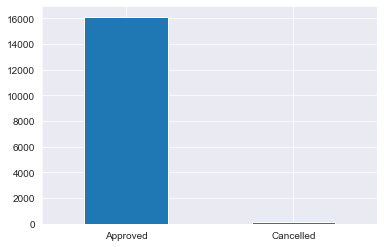

In [36]:
# order_status distribution
order_status_plot = pd.value_counts(comb_df['order_status'], sort=True)
order_status_plot.plot(kind='bar', rot=0)

In [37]:
# order_status percentage distribution
(comb_df['order_status'].value_counts()/comb_df.shape[0]*100)

Approved     99.060831
Cancelled     0.939169
Name: order_status, dtype: float64

In [38]:
# coding order_status to numbers
order_replace = {"order_status" : {"Approved": 1, "Cancelled": 0,}}
comb_df = comb_df.replace(order_replace)
comb_df.order_status.unique()

array([1, 0], dtype=int64)

In [39]:
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16291 entries, 0 to 19967
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 16291 non-null  object 
 1   3yrs_purchases         16291 non-null  int64  
 2   job_industry_category  16291 non-null  object 
 3   wealth_segment         16291 non-null  object 
 4   owns_car               16291 non-null  object 
 5   state                  16291 non-null  object 
 6   property_valuation     16291 non-null  int64  
 7   tenure                 16291 non-null  float64
 8   age_category           16291 non-null  object 
 9   order_status           16291 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 1.4+ MB


In [40]:
comb_df.head()

,gender,3yrs_purchases,job_industry_category,wealth_segment,owns_car,state,property_valuation,tenure,age_category,order_status
0,Male,19,Financial Services,Mass Customer,Yes,VIC,6,10.0,senior,1
1,Male,19,Financial Services,Mass Customer,Yes,VIC,6,10.0,senior,1
2,Male,19,Financial Services,Mass Customer,Yes,VIC,6,10.0,senior,1
3,Female,89,Health,Mass Customer,Yes,NSW,5,10.0,adult,1
4,Female,89,Health,Mass Customer,Yes,NSW,5,10.0,adult,1


In [41]:
# checking for null values
comb_df.isnull().sum()

gender                   0
3yrs_purchases           0
job_industry_category    0
wealth_segment           0
owns_car                 0
state                    0
property_valuation       0
tenure                   0
age_category             0
order_status             0
dtype: int64

In [42]:
# saving the cleaning data to disk 
comb_df.to_csv('transaction data.cvs', index=False)

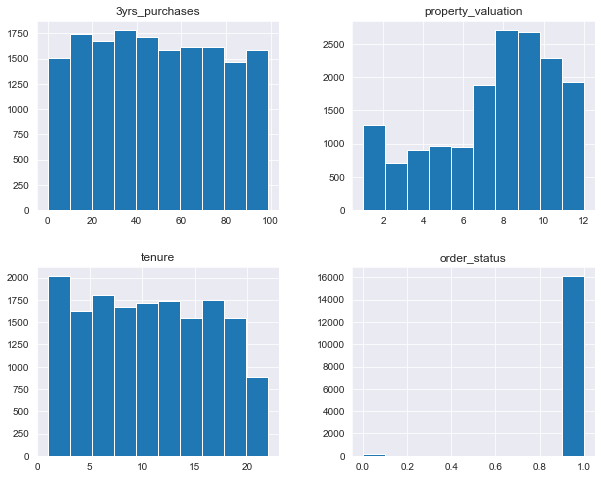

In [43]:
# displaying histogram of numeric data
comb_df.hist(figsize = (10,8));

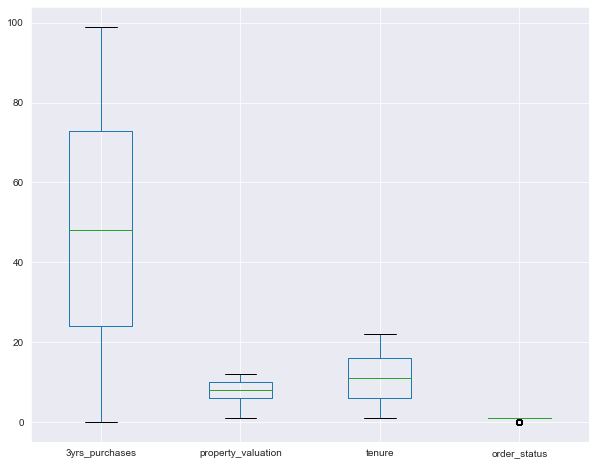

In [44]:
# boxplot of numeric data
comb_df.boxplot(figsize= (10,8));

from the above plots we can see that our data s highly unbalanced

In [45]:
# creating a copy of the data
data = comb_df.copy()
data.head()

,gender,3yrs_purchases,job_industry_category,wealth_segment,owns_car,state,property_valuation,tenure,age_category,order_status
0,Male,19,Financial Services,Mass Customer,Yes,VIC,6,10.0,senior,1
1,Male,19,Financial Services,Mass Customer,Yes,VIC,6,10.0,senior,1
2,Male,19,Financial Services,Mass Customer,Yes,VIC,6,10.0,senior,1
3,Female,89,Health,Mass Customer,Yes,NSW,5,10.0,adult,1
4,Female,89,Health,Mass Customer,Yes,NSW,5,10.0,adult,1


In [46]:
# dropping the order_status which is the target
data = data.drop('order_status', axis=1)
data = pd.get_dummies(data)
X = data
y = comb_df['order_status']

In [47]:
# target
y

0        1
1        1
2        1
3        1
4        1
        ..
19963    1
19964    1
19965    1
19966    1
19967    1
Name: order_status, Length: 16291, dtype: int64

In [48]:
# splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

## Base Logistics Regression Model

In [49]:
# define model
lg1 = LogisticRegression(random_state=13, class_weight=None)

# fit it
lg1.fit(X_train, y_train)

# test
y_pred = lg1.predict(X_test)

# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.9909983633387889
Confusion Matrix: 
[[   0   44]
 [   0 4844]]
Area Under Curve: 0.5
Recall score: 1.0


## Weighted Logistic Regression

In [50]:
# define class weights
w = {1:1, 0:99}

# define model
lg2 = LogisticRegression(random_state=13, class_weight=w)

# fit it
lg2.fit(X_train,y_train)

# test
y_pred2 = lg2.predict(X_test)

# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred2)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred2)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred2)}')
print(f'Recall score: {recall_score(y_test,y_pred2)}')

Accuracy Score: 0.6217266775777414
Confusion Matrix: 
[[  19   25]
 [1824 3020]]
Area Under Curve: 0.5276349373170183
Recall score: 0.6234516928158547


In [51]:
print(lg2.coef_)

[[ 0.0045728  -0.08531016 -0.00771049  0.12943395  0.08837122  0.26539252
  -0.22653799  0.29031125 -0.08651728 -0.30971668  0.08845747 -0.23847553
   0.24208679  0.19280462 -0.12596866  0.22921631  0.11455752 -0.13536218
   0.35316735  0.04632841  0.06567572  0.10580104 -0.12309786  0.26087684
   0.08002619]]


## Randon Forest Classifier

In [52]:
# define the model
rf = RandomForestClassifier(max_features=5, n_estimators=100, class_weight=w, random_state=13)

# fit the model
rf.fit(X_train, y_train)

# test
rf.score(X_test, y_test)

0.9537643207855974

In [53]:
rf.score(X_test, y_test)

0.9537643207855974

In [54]:
y_pred3 = rf.predict(X_test)

In [55]:
accuracy_score(y_pred3, y_test)

0.9537643207855974

In [56]:
# importing the new customer data for predicting
data1 = pd.read_csv('new_cust.csv')

In [57]:
# displaying the first 5 rows
data1.head()

,first_name,last_name,gender,3yrs_purchases,job_industry_category,wealth_segment,owns_car,tenure,state,property_valuation,age_category
0,Chickie,Brister,Male,86,Manufacturing,Mass Customer,Yes,14,QLD,6,senior
1,Morly,Genery,Male,69,Property,Mass Customer,No,16,NSW,11,adult
2,Ardelis,Forrester,Female,10,Financial Services,Affluent Customer,No,10,VIC,5,adult
3,Lucine,Stutt,Female,64,Manufacturing,Affluent Customer,Yes,5,QLD,1,adult
4,Melinda,Hadlee,Female,34,Financial Services,Affluent Customer,No,19,NSW,9,adult


In [58]:
# dropping the firt name and last name in order to predict the data
data_no_name = data1.drop(['first_name', 'last_name'], axis = 1)

In [59]:
# applying numeric coding
data_no_name = pd.get_dummies(data_no_name)
data_no_name.shape

(818, 25)

In [60]:
# predicting the customer data
prediction = lg2.predict(data_no_name)

In [61]:
new = list(prediction)
len(new)

818

In [62]:
# grouping the 1s and 0s
zeros = []
ones = []
for i in prediction:
    if i == 0:
        zeros.append(0)
    else:
        ones.append(1)
    

In [63]:
# Number of potential cancelled purchases
len(zeros)

469

In [64]:
# number of potential approved purchases
len(ones)

349

In [65]:
# converting the prediction to a column
data_no_name['prediction'] = prediction

In [66]:
# adding the prediction column to the dataframe
data1['prediction'] = prediction

In [67]:
data1.head()

,first_name,last_name,gender,3yrs_purchases,job_industry_category,wealth_segment,owns_car,tenure,state,property_valuation,age_category,prediction
0,Chickie,Brister,Male,86,Manufacturing,Mass Customer,Yes,14,QLD,6,senior,1
1,Morly,Genery,Male,69,Property,Mass Customer,No,16,NSW,11,adult,0
2,Ardelis,Forrester,Female,10,Financial Services,Affluent Customer,No,10,VIC,5,adult,0
3,Lucine,Stutt,Female,64,Manufacturing,Affluent Customer,Yes,5,QLD,1,adult,1
4,Melinda,Hadlee,Female,34,Financial Services,Affluent Customer,No,19,NSW,9,adult,0


In [68]:
# customer for targeted sales
potential_customers = data1[data1['prediction'] == 1]
potential_customers

,first_name,last_name,gender,3yrs_purchases,job_industry_category,wealth_segment,owns_car,tenure,state,property_valuation,age_category,prediction
0,Chickie,Brister,Male,86,Manufacturing,Mass Customer,Yes,14,QLD,6,senior,1
3,Lucine,Stutt,Female,64,Manufacturing,Affluent Customer,Yes,5,QLD,1,adult,1
7,Nancie,Vian,Female,74,Retail,Mass Customer,Yes,10,QLD,5,adult,1
8,Duff,Karlowicz,Male,50,Manufacturing,Mass Customer,Yes,5,NSW,10,adult,1
10,Rockwell,Matson,Male,94,Retail,High Net Worth,No,3,QLD,6,young adult,1
...,...,...,...,...,...,...,...,...,...,...,...,...
807,Kellen,Pawelski,Female,83,Manufacturing,High Net Worth,Yes,11,NSW,8,senior,1
808,Jermaine,Bagshawe,Female,60,Property,Mass Customer,Yes,9,QLD,6,senior,1
811,Weidar,Etheridge,Male,38,Financial Services,Mass Customer,Yes,6,NSW,4,senior,1
812,Datha,Fishburn,Female,15,Retail,Mass Customer,No,3,VIC,12,young adult,1
